In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import string
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as tt
import torchvision.models as models
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from keras.preprocessing import image
%matplotlib inline
from copy import copy
import urllib.request
import ssl

In [ ]:
# Mouting drive content
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:
# Relative Path of dataset
data_dir = '/content/drive/MyDrive/ASL/asl_alphabet'

# Changing to current working directory
os.chdir(data_dir) 

#Lists all the folders within the present directory
classes = os.listdir(data_dir + "/asl_alphabet_train/asl_alphabet_train")

num_of_classes = len(classes)
num_of_classes

29

In [ ]:
#Javascript file to stop collab sessions from terminating
'''function ClickConnect(){
console.log("Working"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)
'''

In [ ]:
# Data transforms (data augmentation)
#Composing the transforms to get a single image using tt.Compose

# Data transforms on training dataset
training_transforms = tt.Compose([#Cropping the image randomly with a padding of 25 in reflect padding mode
                                  tt.RandomCrop(200, padding=25, padding_mode='reflect'),
                                  #Rotating randomly usding torchvision transform
                                  tt.RandomRotation(10),
                                  #flipping the image horizontally; mirror image
                                  tt.RandomHorizontalFlip(),
                                  # random perspective transformation of the image with a probability of 0.2
                                  tt.RandomPerspective(distortion_scale=0.2),
                                  #Converting the images into images of tensor format
                                  tt.ToTensor()
                        ])

#Data transform to Tensor for validation dataset
#Converting the testing dataset images to images of tensor format
validation_transforms = tt.Compose([tt.ToTensor()])

In [ ]:
#Assumes that all files are saved in folders
dataset = ImageFolder(data_dir+'/asl_alphabet_train/asl_alphabet_train')

In [ ]:
#Sets the seed for generating random numbers
random_seed = 11
torch.manual_seed(random_seed);

In [ ]:
#Creating a test dataset of 15/100 the size from the training dataset 
validation_data_size = int(0.15 * len(dataset))

#Creating a test set from training dataset
training_data_size = len(dataset) - validation_data_size


training_data, validation_data = random_split(dataset, [training_data_size, validation_data_size])
print("Length of Training data: ",len(training_data))
print("Length of Validation data: ",len(validation_data))

Length of Training data:  73960
Length of Validation data:  13051


In [ ]:
#Creating training dataset and testing dataset using the torchvision transforms
training_data.dataset = copy(dataset)
training_data.dataset.transform = training_transforms
validation_data.dataset.transform = validation_transforms

In [ ]:
#DataLoader wraps an iterable around the training dataset
batch_size = 50
train_data_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#DataLoader wraps an iterable around the test Dataset
validation_data_loader = DataLoader(validation_data, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 200, 200])
Label: J


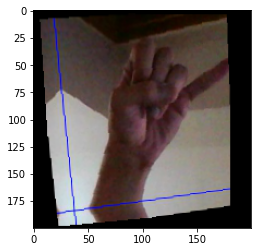

In [ ]:
#Getting a image and corresponding label yfrom training dataset
img, label = training_data[0]
#Size of torch image
print(img.shape)
#Label of the image
print('Label:', dataset.classes[label])
#The image is plotted after the image is permuted and rearranged
plt.imshow(img.permute(1,2,0))

torch.Size([3, 200, 200])
Label: G


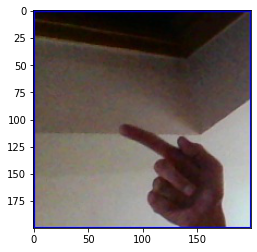

In [ ]:
#Getting a image and corresponding label from test dataset
img, label = validation_data[0]
print(img.shape)
print('Label:', dataset.classes[label])
plt.imshow(img.permute(1,2,0))

In [ ]:
#function for displaying a batch of images
def show_batch(data_loader):
    for images, labels in data_loader:
       #creating subplots so a wide range of images are iterated over and output
        fig, ax = plt.subplots(figsize=(12, 12))
        #X and Y axes tick locations are defined
        ax.set_xticks([]); ax.set_yticks([])
        #The images are plotted
        ax.imshow(make_grid(images[:49], nrow=7).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


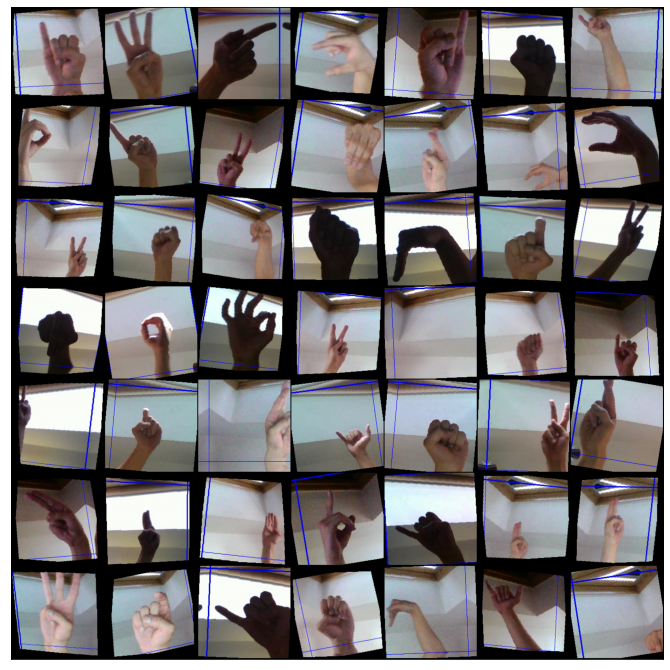

In [ ]:
#Sample of the Training dataset is plotted in batches
show_batch(train_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


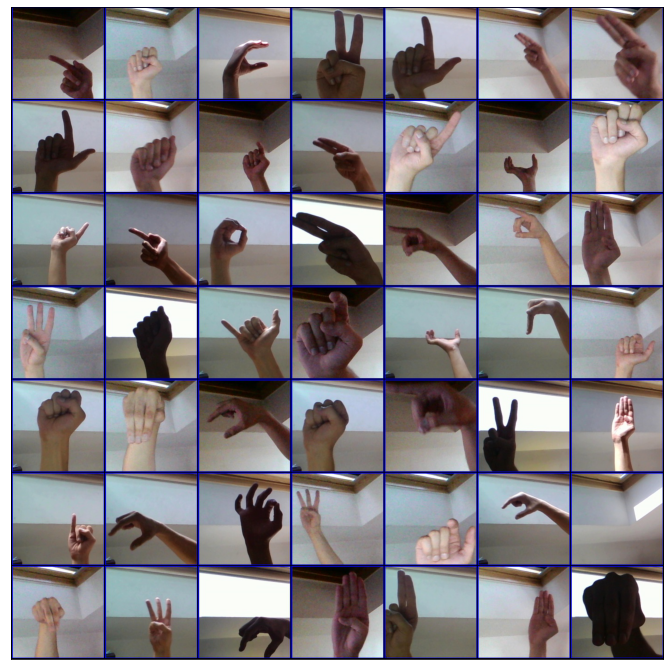

In [ ]:
#Sample of the Testing dataset is plotted in batches
show_batch(validation_data_loader)

In [ ]:
#Function for indicating if CUDA is currently available
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
#Specifies the device type responsible to load a tensor into memory
def to_device(data, device):
  #If data is a list or tuple, moves data to device (cpu or gpu)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
        #if no data is available, raises an exception
    return data.to(device, non_blocking=True)

In [ ]:
#Wraps a dataloader to move data to the device
class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    #Returns a sequential batch of data after moving it to device    
    def __iter__(self):
        for i in self.dataloader: 
            yield to_device(i, self.device)
    
    #Returns length of data
    def __len__(self):
        return len(self.dataloader)

In [ ]:
#Type of device being utilized
device = get_device()
device

device(type='cuda')

In [ ]:
train_data_loader = DeviceDataLoader(train_data_loader, device)
validation_data_loader = DeviceDataLoader(validation_data_loader, device)

In [ ]:
#Returns accuracy of the data

def accuracy(outputs, labels):
  # Returns the maximum value of elements in tensor
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
#Base Class for Image Classification Neural Network Module

class ImageClassificationBase(nn.Module):
    
    #Calculation of loss from the training dataset
    def training_step(self, batch):
        #Splitting the batch into images and labels
        images, labels = batch 
        # Generating predictions
        output = self(images) 
        # Computes the cross entropy loss between otuput and target labels                 
        loss = F.cross_entropy(output, labels)
        return loss
    
    #Calculation of loss from validation dataset
    def validation_step(self, batch):
        #Splitting the batch into images and labels
        images, labels = batch 
        # Generating predictions
        output = self(images)     
        # Computes the cross entropy loss between otuput and target labels                   
        loss = F.cross_entropy(output, labels) 
        # Calculate accuracy of output and label
        acc = accuracy(output, labels)           
        return {'Validation loss': loss.detach(), 'Validation Accuracy': acc}

   #Calculates loss and accuracies of Validation Epoch 
    def validation_epoch(self, outputs):
        batch_loss = [x['Validation loss'] for x in outputs]
        # Stacking losses and calculating average
        epoch_loss = torch.stack(batch_loss).mean()   

        batch_accuracies = [x['Validation Accuracy'] for x in outputs]
        # Stacking losses and calculating average
        epoch_accuracy = torch.stack(batch_accuracies).mean()  

        return {'Validation loss': epoch_loss.item(), 'Validation Accuracy': epoch_accuracy.item()}
    
    def entire_epoch(self, epoch, result):
        print("Epoch [{}], Validation loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, result['Validation loss'], result['Validation Accuracy']))

In [ ]:
#Resnet from Image Classification NNs Module
class ASLResnet(ImageClassificationBase):

    def __init__(self):
        super().__init__()
        # Using a pretrained ResNet 34 model with transfer learning
        self.network = models.resnet34(pretrained=True)
        # Calculating features for input layer
        num_of_features = self.network.fc.in_features
        # Applies linear transformation to data
        self.network.fc = nn.Linear(num_of_features, 29)
    
    #Input an in_feature
    def forward(self, x):
        return self.network(x)
    
    # Function for freezing the residual layers parameters
    def freeze(self):
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    # Unfreezes the residual layers parameters
    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
#Moves Resnet Model to device
model = to_device(ASLResnet(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ASLResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
# Sets all of the requires_grad flags to false
@torch.no_grad()
#Returns Validation dataset loss and accuracies for an entire epoch
def evaluate(model, validation_loader):
    #Sets model in inference mode
    model.eval()
    outputs = [model.validation_step(batch) for batch in validation_loader]
    return model.validation_epoch(outputs)

In [ ]:
#Function for getting learning rate from optimizer param_groups
def get_learning_rate(optimizer):
    for parameter_group in optimizer.param_groups:
        return parameter_group['lr']

In [ ]:
def fit_an_epoch(epochs, max_learning_rate, model, train_loader, validation_loader, 
                  weight_decay=0, grad_clip=None, optimizer_function=torch.optim.SGD):
  
    # Releases all unoccupied cached memory
    torch.cuda.empty_cache()

    history = []
    
    # Creates an optimizer with weight decay
    optimizer = optimizer_function(model.parameters(), max_learning_rate, weight_decay=weight_decay)

    # Set up one cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_learning_rate, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        learning_rates = []

        for batch in train_loader:
            train_loss = model.training_step(batch)
            train_losses.append(train_loss)
            train_loss.backward()
            
            # Gradient clipping and normalising parameter values 
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            #Updates the parameters
            optimizer.step()
            optimizer.zero_grad()
            
            #Records & updates learning rate
            learning_rates.append(get_learning_rate(optimizer))
            scheduler.step()
        
        # Validation phase
        result = evaluate(model, validation_loader)

        #Stacks losses and calculates the average of each item
        result['train_loss'] = torch.stack(train_losses).mean().item()

        result['learning_rates'] = learning_rates
        model.entire_epoch(epoch, result)
        history.append(result)
    return history

In [ ]:
#Returns Validation dataset loss and accuracies
history = [evaluate(model, validation_data_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'Validation Accuracy': 0.023432118818163872,
  'Validation loss': 3.5938405990600586}]

In [ ]:
#Freezes all residual layers
model.freeze()

In [ ]:
epochs = 1
max_learning_rate = 1e-4 

In [ ]:
#wall time for the entire cell 
%%time
#Calculates Validation loss and Validation accuracy
history += fit_an_epoch(epochs, max_learning_rate, model, train_data_loader, validation_data_loader, 
                             grad_clip=0.1, 
                             weight_decay=1e-4, 
                             optimizer_function=torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], Validation loss: 0.0030, Validation Accuracy: 0.9996
CPU times: user 9min 43s, sys: 7min 42s, total: 17min 25s
Wall time: 1h 15min 21s


In [ ]:
#Unfreezes all the forzen residual layers
model.unfreeze()

In [ ]:
#wall time for the entire cell 
%%time
#Calculates Validation loss and Validation accuracy
history += fit_an_epoch(epochs, 1e-5, model, train_data_loader, validation_data_loader, 
                             grad_clip=0.1, 
                             weight_decay=1e-4, 
                             optimizer_function=torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], Validation loss: 0.0009, Validation Accuracy: 1.0000
CPU times: user 9min 34s, sys: 7min 8s, total: 16min 42s
Wall time: 17min 54s


In [ ]:
#Plotting the accuracies for the epochs in a graph

def plot_accuracies(history):
    accuracies = [x['Validation Accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

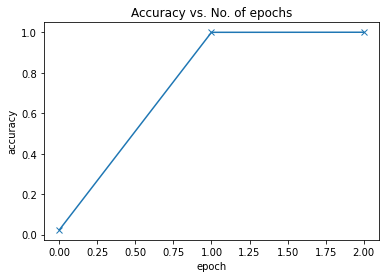

In [ ]:
plot_accuracies(history)

In [ ]:
#Plotting the losses against epochs
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    validation_losses = [x['Validation loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(validation_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

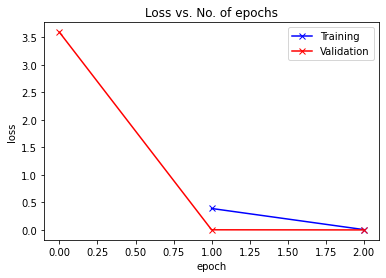

In [ ]:
plot_losses(history)

In [ ]:
#Plotting the learning rates
def plot_lrs(history):
    learning_rates = np.concatenate([x.get('learning_rates', []) for x in history])
    plt.plot(learning_rates)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

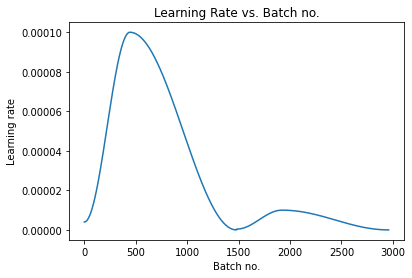

In [ ]:
plot_lrs(history)


In [ ]:
def predict_image(img, model):
    # Convert to a batch of sizes 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
test_dataset = ImageFolder(data_dir+'/asl_alphabet_test')

In [ ]:
len(test_dataset)

28

In [ ]:
test_ds, _ = random_split(test_dataset, [28, 0])

In [ ]:
test_ds.dataset.transform = tt.Compose([tt.ToTensor()])

Predicted: space


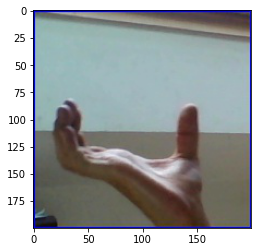

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: S


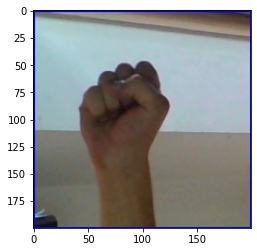

In [ ]:
img, label = test_ds[1]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

Predicted: L


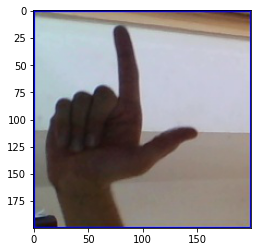

In [ ]:
img, label = test_ds[16]
plt.imshow(img.permute(1, 2, 0))
print('Predicted:', predict_image(img, model))

In [ ]:
os.chdir('/content/drive/MyDrive/ASL')

In [ ]:
torch.save(model.state_dict(), 'asl-colored-resnet34.pth')

In [ ]:
model2 = to_device(ASLResnet(), device)

In [ ]:
model2.load_state_dict(torch.load('asl-colored-resnet34.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, validation_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'Validation Accuracy': 1.0, 'Validation loss': 0.0009382462594658136}

In [ ]:
evaluate(model2, train_data_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'Validation Accuracy': 0.9993243217468262,
 'Validation loss': 0.002689757850021124}

In [ ]:
# Comparing our current model's accuracy with a new handwritten CNN model
import keras


train = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/ASL/asl_alphabet/asl_alphabet_train/asl_alphabet_train/', # Folder of folders of letters
    labels='inferred', # They can be inferred from folder names (A, B, C... del, nothing, space)
    label_mode='categorical', # We have different types of letters
    image_size=(200, 200),
    validation_split=0.2,
    subset='training',
    seed=2333, 
    shuffle=True,
)

Found 87011 files belonging to 29 classes.
Using 69609 files for training.


In [ ]:
valid = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/ASL/asl_alphabet/asl_alphabet_train/asl_alphabet_train/',
    labels='inferred',
    label_mode='categorical',
    image_size=(200, 200),
    validation_split=0.2,
    subset='validation',
    seed=2333,
    shuffle=True,
)

Found 87011 files belonging to 29 classes.
Using 17402 files for validation.


In [ ]:
print(train.class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
from keras import layers, Sequential

In [ ]:
ker_aug = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.25, seed=2333), 
])

In [ ]:
aug_train = train.map(
    lambda x, y: (ker_aug(x, training=True), y)
)


In [ ]:
small_cnn = Sequential([
    keras.Input((None, None, 3)),
    layers.Resizing(64, 64), 
    ker_aug,
    layers.Rescaling(1.0/255),
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(64, 64, 3)), 
    layers.MaxPooling2D(3, 3),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(96, activation='relu'),
    layers.Dense(29, activation='softmax')
])

In [ ]:
small_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
small_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 32)        9248      
                                                      

In [ ]:
monitor = keras.callbacks.ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
history_small = small_cnn.fit(
    train,
    epochs=20,
    validation_data=valid,
    callbacks=monitor
)

Epoch 1/20


2022-04-24 03:42:22.817249: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-24 03:42:24.339216: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2175/2175 [==============================] - 200s 89ms/step - loss: 2.4463 - accuracy: 0.2660 - val_loss: 1.7134 - val_accuracy: 0.4459
Epoch 2/20
2175/2175 [==============================] - 80s 37ms/step - loss: 1.4142 - accuracy: 0.5407 - val_loss: 1.3566 - val_accuracy: 0.5490
Epoch 3/20
2175/2175 [==============================] - 78s 36ms/step - loss: 1.0183 - accuracy: 0.6631 - val_loss: 0.9809 - val_accuracy: 0.6799
Epoch 4/20
2175/2175 [==============================] - 79s 36ms/step - loss: 0.8061 - accuracy: 0.7295 - val_loss: 0.8216 - val_accuracy: 0.7176
Epoch 5/20
2175/2175 [==============================] - 80s 37ms/step - loss: 0.6674 - accuracy: 0.7751 - val_loss: 0.6692 - val_accuracy: 0.7736
Epoch 6/20
2175/2175 [==============================] - 78s 36ms/step - loss: 0.5746 - accuracy: 0.8060 - val_loss: 0.5366 - val_accuracy: 0.8119
Epoch 7/20
2175/2175 [==============================] - 79s 36ms/step - loss: 0.5071 - accuracy: 0.8274 - val_loss: 0.5131 - val_accur

In [ ]:
def plot_acc(history, ax = None, xlabel = 'Epoch #', lowerylim = 0):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
        f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    
    ax.axhline(1.0/29, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    
    ax.legend(loc = 'lower center')    
    ax.set_ylim([lowerylim, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

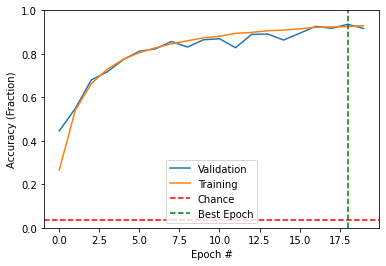

In [ ]:
plot_acc(history_small)

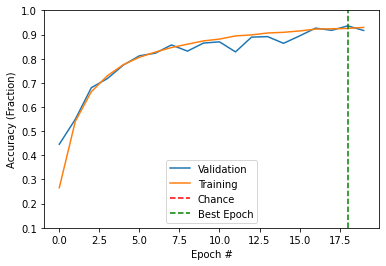

In [ ]:
plot_acc(history_small, lowerylim=0.1)

In [ ]:
preds1 = []
for i in range(len(imgarr)):
    pred = small_cnn.predict(np.asarray(imgarr[i]).reshape(-1, 200, 200, 3))
    preds1.append(train.class_names[np.argmax(pred)])
print(preds1)

['B', 'E', 'L', 'N', 'S', 'D', 'G', 'J', 'W', 'M', 'nothing', 'X', 'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'R', 'space', 'O', 'B', 'R', 'F', 'Z', 'H', 'K']


In [ ]:
print(test_labels)

['A', 'E', 'L', 'N', 'S', 'D', 'G', 'I', 'W', 'M', 'nothing', 'X', 'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'U', 'space', 'O', 'B', 'R', 'F', 'Z', 'J', 'K']


In [ ]:
basic_cnn = Sequential([
    keras.Input((None, None, 3)),
    layers.Resizing(64, 64),
    ker_aug,
    layers.Rescaling(1./255), 
    layers.Conv2D(128, 5, padding='same', activation='relu', input_shape=(64, 64, 3)),
    layers.AveragePooling2D(2, 2),
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(29, activation='softmax') # there are 29 categories
])



In [ ]:
basic_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
basic_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 64, 64, 3)         0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       9728      
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
monitor = keras.callbacks.ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
history = basic_cnn.fit(
    train,
    epochs=10, 
    validation_data=valid,
    callbacks=monitor
)

Epoch 1/10
2175/2175 [==============================] - 83s 38ms/step - loss: 2.4245 - accuracy: 0.2649 - val_loss: 1.6002 - val_accuracy: 0.4752
Epoch 2/10
2175/2175 [==============================] - 81s 37ms/step - loss: 1.2424 - accuracy: 0.5899 - val_loss: 0.8555 - val_accuracy: 0.7029
Epoch 3/10
2175/2175 [==============================] - 82s 38ms/step - loss: 0.8064 - accuracy: 0.7270 - val_loss: 0.6103 - val_accuracy: 0.7847
Epoch 4/10
2175/2175 [==============================] - 82s 38ms/step - loss: 0.6023 - accuracy: 0.7948 - val_loss: 0.4311 - val_accuracy: 0.8487
Epoch 5/10
2175/2175 [==============================] - 86s 39ms/step - loss: 0.4803 - accuracy: 0.8357 - val_loss: 0.3511 - val_accuracy: 0.8834
Epoch 6/10
2175/2175 [==============================] - 84s 39ms/step - loss: 0.4042 - accuracy: 0.8612 - val_loss: 0.3367 - val_accuracy: 0.8864
Epoch 7/10
2175/2175 [==============================] - 83s 38ms/step - loss: 0.3557 - accuracy: 0.8766 - val_loss: 0.2594 -

In [ ]:
basic_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 64, 64, 3)         0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       9728      
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)       

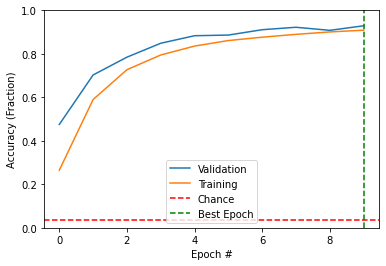

In [ ]:
plot_acc(history)

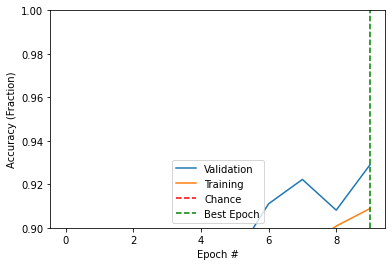

In [ ]:
plot_acc(history, lowerylim=0.9)

In [ ]:
preds1 = []
for i in range(len(imgarr)):
    pred = small_cnn.predict(np.asarray(imgarr[i]).reshape(-1, 200, 200, 3))
    preds1.append(train.class_names[np.argmax(pred)])
print(preds1)

['B', 'E', 'L', 'N', 'S', 'D', 'G', 'J', 'W', 'M', 'nothing', 'X', 'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'R', 'space', 'O', 'B', 'R', 'F', 'Z', 'H', 'K']


In [ ]:
print(test_labels)

['A', 'E', 'L', 'N', 'S', 'D', 'G', 'I', 'W', 'M', 'nothing', 'X', 'H', 'Q', 'C', 'T', 'P', 'V', 'Y', 'U', 'space', 'O', 'B', 'R', 'F', 'Z', 'J', 'K']
